## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

import seaborn as sns 
from sklearn.metrics import accuracy_score

## Khám phá dữ liệu

In [2]:
data_df = pd.read_csv('Data/data.csv',index_col = 'ID') # Cho cột index là cột 0 
data_df.head()

,State Name,State Abbreviation,Wind Direction,Created,Applicable Date,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility,Predictability
ID,,,,,,,,,,,,,
4815613784489984,Clear,c,24.918324,2016-01-01T15:50:46.783160Z,2016-01-01,22.5975,33.8400,32.39,5.850634,1015.0,57.0,11.968541,68
5117614409908224,Light Cloud,lc,111.222444,2016-01-02T15:50:46.519900Z,2016-01-02,24.2150,33.9675,32.26,4.975470,1014.0,61.0,11.687371,70
5845769609281536,Light Rain,lr,54.357487,2016-01-03T15:50:46.178120Z,2016-01-03,24.6425,33.0950,32.36,5.751001,1014.0,66.0,9.814558,75
4887679040749568,Heavy Cloud,hc,105.343582,2016-01-04T15:50:46.861790Z,2016-01-04,24.6750,33.3150,32.92,8.274074,1014.0,63.0,11.006659,71
6722346127720448,Light Cloud,lc,93.195824,2016-01-05T15:50:46.201860Z,2016-01-05,24.3425,33.3975,33.14,8.083090,1013.0,63.0,11.890248,70


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [3]:
# Kích thước của dữ liệu
data_df.shape

(1827, 13)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát bộ dữ liệu ta thấy mỗi dòng chứa thông tin thời tiết của mỗi ngày

### Dữ liệu có các dòng bị lặp không?

In [4]:
# Kiểm tra dữ liệu thu thập được có bị trùng không
data_df.index.duplicated().sum()

0

*Dữ liệu bị trùng lắp là do ID của các năm có thể sẽ bị trùng lắp lại, ta sẽ xử lý cột này ở bước tiền xử lý*

### Mỗi cột có ý nghĩa gì?

Xem file "description.txt"

In [5]:
with open('description.txt', 'r',encoding = 'utf-8') as f:
    print(f.read())

***** DESCRIPTION WEATHER *****
Vị trí: Hồ Chí Minh City
Thời tiết 4 năm (2016,2017,2018,2019)
Predictability:
+ 80: Thunder
+ 77: Heavy Rain
+ 75: Light Rain
+ 73: Showers
+ 71: Heavy Cloud
+ 70: Light Cloud
+ 68: Clear

ID: id của mỗi ngày trong từng năm
State Name: tên trạng thái của ngày (Clear,Light Cloud,...)
State Abbreviation: viết tắt của trạng thái (c,lc,...)
Wind Direction: Hướng gió
Created: Thời gian cụ thể trong ngày
Applicable Date: Ngày áp dụng
Min Temp: Nhiệt độ tối thiểu
Max Temp: Nhiệt đố tối đa
The Temp: Nhiệt độ
Wind Speed: Tốc độ của gió
Air Pressure: Áp suất không khí
Humidity: Độ ẩm
Visibility: Khoảng cách nhìn thấy






## Đưa ra câu hỏi cần trả lời

Với bộ dữ liệu này thì cột output ta sẽ lấy là cột Predictability để phân ra mưa hay không mưa  
Output - *0: Không mưa,1: Có khả năng mưa,2: Mưa* - ứng với thời tiết được tính từ input - *các chỉ số trong ngày* - được tính từ công thức nào ?   
Tạm thời ta để input là các chỉ số trong ngày, ta sẽ xử lý các thuộc tính ở bước tiền xử lý  
Việc tìm ra câu trả lời sẽ giúp cho mọi người biết được thời tiết như thế nào để có thể chuẩn bị tốt cho một ngày (thực tế trong cuộc sống )  
VD: Nếu biết trời mưa, khi đi ra ngoài ta sẽ cầm theo dù (ô) hay là áo mưa, giúp cho các bác nông dân tránh bị "chạy thóc" khi gặp phải ngày mưa,...  

### Cảm hứng:  
Vô tình vào tuần sau khi được nghỉ các môn học, em có về quê chơi với ông bà, vô tình vào 1 hôm em đi chơi xung quanh xóm thì trời bất ngờ đổ mưa, em chạy về nhà vô tình trên đường thầy nhiều nhà cô chú làm nông phải vội vã "chạy thóc", nếu không kịp sẽ bị mưa cuốn trôi, ảnh hưởng đến nhiều thứ nên bọn em đã quyết định đặt câu hỏi liên quan tới thời tiết ạ.

## Khám phá dữ liệu (để biết cách tách các tập)

Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít  
+ 80: Thunder -> Mưa (2)  
+ 77: Heavy Rain -> Mưa (2)  
+ 75: Light Rain -> Mưa (2)  
+ 73: Showers -> Mưa (2)  
+ 71: Heavy Cloud -> Mây nhiều -> Có khả năng mưa (1)  
+ 70: Light Cloud -> Mây ít -> Ít có khả năng mưa -> Ta sẽ đưa vào là không mưa -> Không mưa (0)  
+ 68: Clear -> Không mưa (0)  

In [6]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['Predictability'].dtype

dtype('int64')

In [7]:
# Cột output có giá trị thiếu không?
data_df['Predictability'].isna().sum()

0

In [8]:
# Tỉ lệ các lớp trong cột output?
data_df['Predictability'].value_counts(normalize=True) * 100

77    33.223864
75    23.973727
70    15.270936
71    14.723591
73    11.056377
68     0.985222
80     0.766284
Name: Predictability, dtype: float64

In [9]:
#Chuyển cột output sang dạng nhị phân (0,1)
data_df.loc[(data_df.Predictability < 71), 'Predictability'] = 0
data_df.loc[(data_df.Predictability == 71), 'Predictability'] = 1
data_df.loc[(data_df.Predictability > 71), 'Predictability'] = 2

In [10]:
# Tỉ lệ các lớp trong cột output?
data_df['Predictability'].value_counts(normalize=True) * 100

2    69.020252
0    16.256158
1    14.723591
Name: Predictability, dtype: float64

Nhìn có vẻ với bộ dữ liệu api trên trang metaweather thì thành phố Hồ Chí Minh hay mưa :)))  
Ok, như vậy không có vấn đề gì cả 

## Tiền xử lý (tách các tập)

Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập validation và tập test

In [11]:
# Tách X và y
y_sr = data_df["Predictability"] # sr là viết tắt của series
X_df = data_df.drop("Predictability", axis=1)

In [12]:
# Tách tập huấn luyện(train và validation) và tập test theo tỉ lệ 80%:20%
Tr_X_df, test_X_df, Tr_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)

In [13]:
#Tách tập huấn luyện train và validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(Tr_X_df, Tr_y_sr, test_size=0.3, random_state=0)

In [14]:
train_X_df.shape

(1022, 12)

In [15]:
train_y_sr.shape

(1022,)

In [16]:
val_X_df.shape

(439, 12)

In [17]:
val_y_sr.shape

(439,)

In [18]:
test_X_df.shape

(366, 12)

In [19]:
test_y_sr.shape

(366,)

In [20]:
train_X_df.head().index

Int64Index([4693872194093056, 5332141575503872, 4828622292516864,
            6239097135824896, 5013966445084672],
           dtype='int64', name='ID')

## Khám phá dữ liệu (tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [21]:
train_X_df.dtypes

State Name             object
State Abbreviation     object
Wind Direction        float64
Created                object
Applicable Date        object
Min Temp              float64
Max Temp              float64
The Temp              float64
Wind Speed            float64
Air Pressure          float64
Humidity              float64
Visibility            float64
dtype: object

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [22]:
train_X_df.dtypes[train_X_df.dtypes != object]

Wind Direction    float64
Min Temp          float64
Max Temp          float64
The Temp          float64
Wind Speed        float64
Air Pressure      float64
Humidity          float64
Visibility        float64
dtype: object

In [23]:
num_cols = ['Wind Direction','Min Temp','Max Temp','The Temp','Wind Speed','Air Pressure','Humidity','Visibility']
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Wind Direction,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility
missing_ratio,0.000000,0.000,0.000,0.00,0.000000,0.000,0.0,0.100000
min,1.943751,19.495,12.930,23.47,1.479793,996.445,44.0,2.173556
lower_quartile,110.400000,24.200,29.900,28.80,3.700000,1009.900,65.0,8.200000
median,153.900000,25.000,31.000,29.90,4.900000,1012.500,74.0,10.500000
upper_quartile,237.900000,25.900,32.300,31.30,6.800000,1014.400,81.0,12.100000
max,359.171590,29.185,38.035,37.18,13.850926,1020.140,94.0,18.473366


Theo như bảng ở trên, ta thấy không có thuôc tính (dạng số) bị thiếu dữ liệu

### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [24]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(train_X_df.columns) - set(num_cols))
df = train_X_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,Applicable Date,Created,State Name,State Abbreviation
missing_ratio,0,0,0,0
num_values,1022,1022,7,7
value_ratios,"{'2019-03-05': 0.1, '2016-12-04': 0.1, '2016-06-15': 0.1, '2017-01-26': 0.1, '2017-08-12': 0.1, '2018-12-06': 0.1, '2019-10-16': 0.1, '2018-06-28': 0.1, '2016-01-24': 0.1, '2018-06-03': 0.1, '2016...","{'2017-08-18T14:59:58.900170Z': 0.1, '2018-11-09T15:36:59.228778Z': 0.1, '2016-01-17T15:50:46.916980Z': 0.1, '2016-11-30T15:04:59.124920Z': 0.1, '2016-04-01T14:42:47.789380Z': 0.1, '2020-12-17T16:...","{'Heavy Rain': 34.0, 'Light Rain': 22.6, 'Light Cloud': 16.3, 'Heavy Cloud': 15.2, 'Showers': 10.3, 'Clear': 0.9, 'Thunder': 0.8}","{'hr': 34.0, 'lr': 22.6, 'lc': 16.3, 'hc': 15.2, 's': 10.3, 'c': 0.9, 't': 0.8}"


Tương tự như thuộc tính không phải dạng số (categorical) cũng không bị thiếu dữ liệu

## Tiền xử lý (tập huấn luyện) 

Đầu tiên ta sẽ bỏ một số cột sau:  
- Bỏ cột 'ID' , thay vào đó ta sẽ để cột 'Applicable Date' làm cột index  
- Bỏ cột 'State Name' và cột 'State Abbreviation' vì đây là 2 cột tương tự giống với cột output  
- Bỏ cột 'Created' vì cột này không có nhiều tác dụng trong việc đánh giá mô hình

In [25]:
class ColDropper(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        # YOUR CODE HERE
        df_transform = X_df.copy()
        df_transform.set_index('Applicable Date',inplace = True)
        df_transform.drop(['State Name','State Abbreviation','Created'],axis = 1,inplace = True)
        return df_transform

In [26]:
col_dropper = ColDropper()
col_dropper.fit(train_X_df)
col_dropper.transform(train_X_df)

,Wind Direction,Min Temp,Max Temp,The Temp,Wind Speed,Air Pressure,Humidity,Visibility
Applicable Date,,,,,,,,
2018-07-04,246.833406,24.970000,29.976667,29.110,9.199393,1012.910,74.0,10.575738
2016-09-05,265.199886,26.327500,31.875000,29.560,6.623241,1000.175,83.0,5.317695
2016-09-14,251.350461,24.685000,31.112500,29.750,8.062155,1012.830,80.0,11.525193
2016-05-27,225.982636,26.426667,32.043333,30.130,8.445431,1008.000,76.0,7.551835
2020-02-29,113.158931,24.355000,31.080000,30.960,5.833753,1010.500,63.0,13.445230
...,...,...,...,...,...,...,...,...
2016-12-10,320.704514,24.296000,29.198000,28.725,2.642794,1011.775,80.0,6.159342
2018-04-10,110.771893,26.863333,34.320000,34.350,4.840252,1014.655,58.0,10.433444
2017-12-28,83.851553,24.165000,30.505000,29.435,3.063802,1015.680,80.0,8.133438


Như ta thấy ở trên thì toàn bộ thuộc tính chỉ còn lại thuộc tính dạng số (numerical): 'Wind Direction', 'Min Temp', 'Max Temp', 'The Temp', 'Wind Speed', 'Air Pressure', 'Humidity', 'Visibility'  
Mặc dù không có dữ liệu bị thiếu trên các thuộc tính dạng kiểu số nhưng ta cũng cần phải ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới (Class MissingValues sẽ làm việc đó)  
Sau khi đã điền giá trị thiếu ta sẽ chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn (Class Standarized sẽ làm việc này)

In [27]:
class MissingValues(BaseEstimator, TransformerMixin):
    def fit(self,X, y=None):
        #mean  (num_cols)
        self.imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
        self.imp_mean = self.imp_mean.fit(X[X.columns])
        return self
    def transform(self, X, y=None):
        X[X.columns] = self.imp_mean.transform(X[X.columns])
        return X
class Standardized(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        scaler = StandardScaler()
        self.scaled = scaler.fit(X)
        return self
    def transform(self, X, y=None):
        #Standardized
        result = self.scaled.transform(X)
        return result
    
preprocess_pipeline = make_pipeline(ColDropper(),MissingValues(),Standardized())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocessed_train_X

array([[ 0.95687809, -0.02694965, -0.56662754, ...,  0.26198247,
         0.11497783,  0.14469734],
       [ 1.18611733,  0.92802899,  0.30112651, ..., -3.20046584,
         0.95365041, -1.80664013],
       [ 1.01325722, -0.22744241, -0.04742263, ...,  0.24023171,
         0.67409288,  0.49705419],
       ...,
       [-1.07736231, -0.59325375, -0.32511917, ...,  1.01510236,
         0.67409288, -0.76167608],
       [ 1.16173858,  0.1735431 , -0.3079774 , ..., -0.09554556,
         1.23320793,  0.07816923],
       [-0.43480697,  0.10436724,  0.60205966, ...,  0.35850144,
        -1.56236731,  0.36780287]])

## Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất 

#### Mô hình Neural Net

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số `hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500`)  

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPClassifier` với 5 giá trị khác nhau: 0.1, 1, 10, 100, 1000.
- Siêu tham số `hidden_layer_sizes` (số lớp ẩn trong Neural) của `MLPClassifier` với 5 giá trị khác nhau: 5,10,20,50,100

In [28]:
#Tạo full pipeline  
full_pipeline = make_pipeline(ColDropper(),MissingValues(),Standardized(),MLPClassifier(hidden_layer_sizes=(20),activation='tanh',solver='lbfgs',random_state= 0,max_iter = 2500))
alpha_l = []
hid_l = []
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
hidden_layers = [5, 10, 20, 50, 100]
best_val_err = float('inf'); best_alpha = None; best_num_top_titles = None
for alpha in alphas:
    for hidden_layer in hidden_layers:
        alpha_l.append(alpha)
        hid_l.append(hidden_layer)
        full_pipeline.set_params(mlpclassifier__alpha=alpha,mlpclassifier__hidden_layer_sizes = (hidden_layer))
        full_pipeline.fit(train_X_df,train_y_sr)
        train_errs.append((1-full_pipeline.score(train_X_df,train_y_sr))*100)
        val_errs.append((1-full_pipeline.score(val_X_df,val_y_sr))*100)
best_val_err = min(val_errs)
best_alpha = alpha_l[val_errs.index(best_val_err)]
best_hidden_layer = hid_l[val_errs.index(best_val_err)]
'Finish!'

'Finish!'

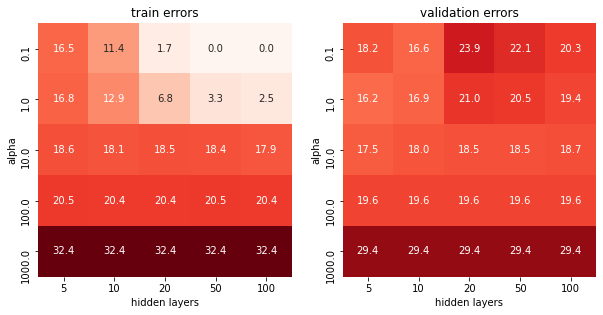

In [29]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=hidden_layers)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=hidden_layers)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden layers'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden layers'); plt.ylabel('alpha');

Để ý thấy với hidden layers khác nhau thì sẽ không ảnh hưởng đến độ lỗi của mô hình quá nhiều,để đánh giá mô hình này thì ta sẽ dựa vào alpha

In [30]:
full_pipeline.set_params(mlpclassifier__alpha=best_alpha,mlpclassifier__hidden_layer_sizes = (best_hidden_layer))
full_pipeline.fit(Tr_X_df,Tr_y_sr)

Pipeline(steps=[('coldropper', ColDropper()),
                ('missingvalues', MissingValues()),
                ('standardized', Standardized()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=1, hidden_layer_sizes=5,
                               max_iter=2500, random_state=0,
                               solver='lbfgs'))])

In [31]:
# Đánh giá độ lỗi của mô hình Neural Net trên tập test
predict = full_pipeline.predict(test_X_df)
print(accuracy_score(predict, test_y_sr))

0.8087431693989071


#### Mô hình AdaBoost Classifier

Ta sẽ sử dụng mô hình AdaBoost Classifier để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + AdaBoost Classifier

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `n_estimators`của `AdaBoostClassifier` với 5 giá trị khác nhau: 10,20,50,100,150

In [32]:
#Tạo full pipeline  
full_pipeline = make_pipeline(ColDropper(),MissingValues(),Standardized(),AdaBoostClassifier())
estimators_l = []
# Thử nghiệm với các giá trị khác nhau của siêu tham số n_estimators
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
algorithm = ['SAMME.R']
estis = [10, 20, 50, 100, 150]
best_val_err = float('inf')
best_esti = None

for esti in estis:
    estimators_l.append(esti)
    full_pipeline.set_params(adaboostclassifier__n_estimators=esti)
    full_pipeline.fit(train_X_df,train_y_sr)
    train_errs.append((1-full_pipeline.score(train_X_df,train_y_sr))*100)
    val_errs.append((1-full_pipeline.score(val_X_df,val_y_sr))*100)
best_val_err = min(val_errs)
best_esti = estimators_l[val_errs.index(best_val_err)]
print('Độ lỗi tốt nhất trên tập validation: ',best_val_err)

Độ lỗi tốt nhất trên tập validation:  18.906605922551257


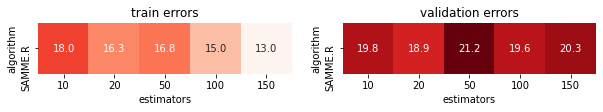

In [33]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(algorithm), -1),
                             index=algorithm, columns=estis)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(algorithm), -1), 
                           index=algorithm, columns=estis)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('estimators'); plt.ylabel('algorithm')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('estimators'); plt.ylabel('algorithm');

In [34]:
# Đánh giá độ lỗi của mô hình AdaBoost Classifier trên tập test
full_pipeline.set_params(adaboostclassifier__n_estimators=best_esti)
full_pipeline.fit(Tr_X_df,Tr_y_sr)
predict = full_pipeline.predict(test_X_df)
print(accuracy_score(predict, test_y_sr))

0.819672131147541


#### Mô hình Decision Tree Classifier

Ngoài ra ta sẽ thử thêm mô hình Decision Tree Classifier với các tham số mặc định

In [35]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = make_pipeline(ColDropper(),MissingValues(),Standardized(),DecisionTreeClassifier())
full_pipeline.fit(train_X_df,train_y_sr)
print("Độ lỗi trên tập train:",(1-full_pipeline.score(train_X_df,train_y_sr))*100)
print("Độ lỗi trên tập validation:",(1-full_pipeline.score(val_X_df,val_y_sr))*100)

Độ lỗi trên tập train: 0.0
Độ lỗi trên tập validation: 26.651480637813208


In [36]:
# Đánh giá độ lỗi của mô hình Decision Tree trên tập test
full_pipeline.fit(Tr_X_df,Tr_y_sr)
predict = full_pipeline.predict(test_X_df)
print(accuracy_score(predict, test_y_sr))

0.7704918032786885


Sau khi thử nghiệm các siêu tham số trên 3 mô hình ở trên, ta thấy mô hình Neural Net đạt độ chính xác tốt nhất với bộ dữ liệu thời tiết này